In [3]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month 2w 5d


In [4]:
%cd /home/ir739wb/ilyarekun/nn_DeiT_25/

/home/ir739wb/ilyarekun/nn_DeiT_25


In [5]:
%pwd

'/home/ir739wb/ilyarekun/nn_DeiT_25'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models import regnet_y_16gf, RegNet_Y_16GF_Weights
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import random

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,garbage_collection_threshold:0.8"

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# Проверка доступных GPU
import subprocess
subprocess.run(["nvidia-smi", "-L"])

class ModifiedModel(nn.Module):
    def __init__(self, base_model):
        super(ModifiedModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.5)  
        self.linear = nn.Linear(100,100)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)  
        x = self.linear(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}, GPU count: {torch.cuda.device_count()}")

data_path = "/home/ir739wb/ilyarekun/nn_DeiT_25/cifar100_imagenet_style"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

train_dataset = datasets.ImageFolder(os.path.join(data_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_path, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)

teacher_model = models.regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_V1)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 100)
teacher_model = ModifiedModel(teacher_model)

teacher_model = teacher_model.to(device)
if torch.cuda.device_count() > 1:
    print("Using DataParallel for multi-GPU training")
    teacher_model = nn.DataParallel(teacher_model)

optimizer = optim.Adam(teacher_model.parameters(), lr=0.0001, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

# Планировщик скорости обучения
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
all_preds = []
all_labels = []

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1s.append(f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        #scheduler.step()  # Обновление скорости обучения
        
train_model(teacher_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=300)

torch.save(teacher_model.state_dict(), 'teacher_regnety160_cifar100.pth')
print("Model weights saved to 'teacher_regnety160_cifar100.pth'")



GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-a3c4b7d3-2308-0714-9328-ffe9888b564c)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-5c73ff1d-c5d0-f175-0241-c80dc2a3b970)
Using device: cuda, GPU count: 2
Using DataParallel for multi-GPU training
Epoch 1/300, Train Loss: 3.3034, Val Loss: 2.3801, Val Acc: 40.18%, Precision: 0.4411, Recall: 0.4018, F1: 0.3749
Epoch 2/300, Train Loss: 2.4348, Val Loss: 2.1837, Val Acc: 45.26%, Precision: 0.4468, Recall: 0.4272, F1: 0.4112
Epoch 3/300, Train Loss: 2.2447, Val Loss: 2.0843, Val Acc: 46.37%, Precision: 0.4475, Recall: 0.4393, F1: 0.4244
Epoch 4/300, Train Loss: 2.1409, Val Loss: 2.0513, Val Acc: 47.99%, Precision: 0.4522, Recall: 0.4495, F1: 0.4351
Epoch 5/300, Train Loss: 2.0495, Val Loss: 1.9101, Val Acc: 49.94%, Precision: 0.4584, Recall: 0.4595, F1: 0.4464
Epoch 6/300, Train Loss: 1.9659, Val Loss: 1.9377, Val Acc: 49.67%, Precision: 0.4623, Recall: 0.4657, F1: 0.4537
Epoch 7/300, Train Loss: 1.8958, Val Loss: 1.8861, Val Acc: 49.96%, Precision: 0.4657

In [ ]:
print(all_labels)

In [ ]:
torch.cuda.empty_cache()

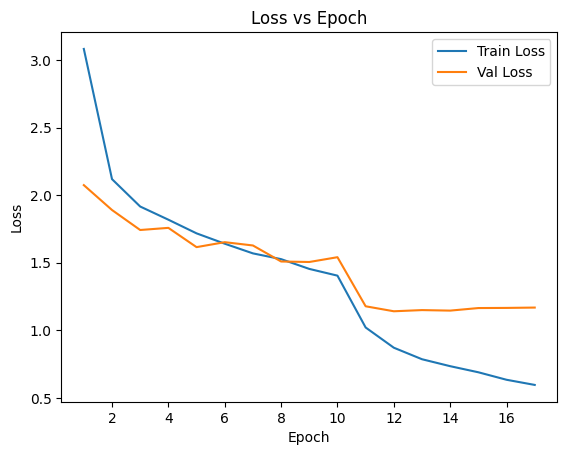

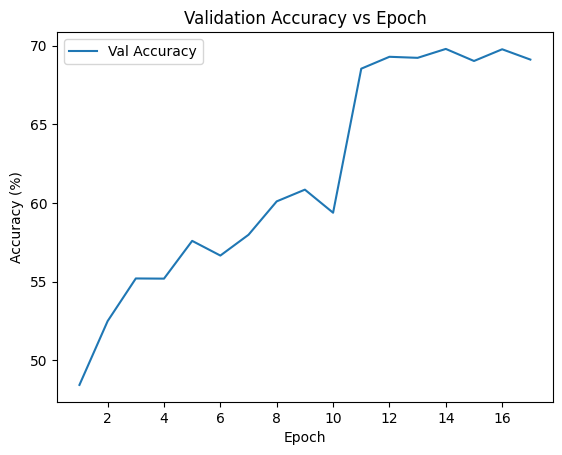

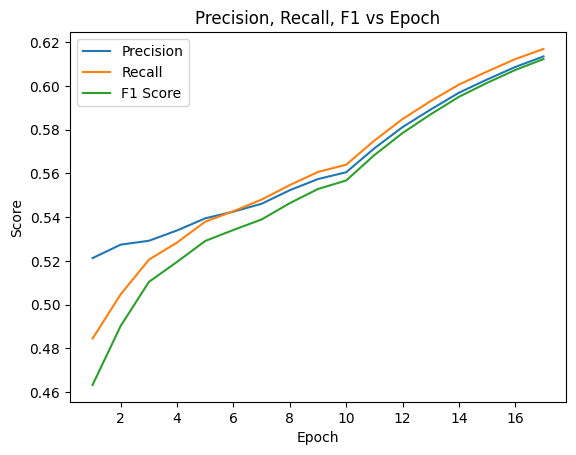

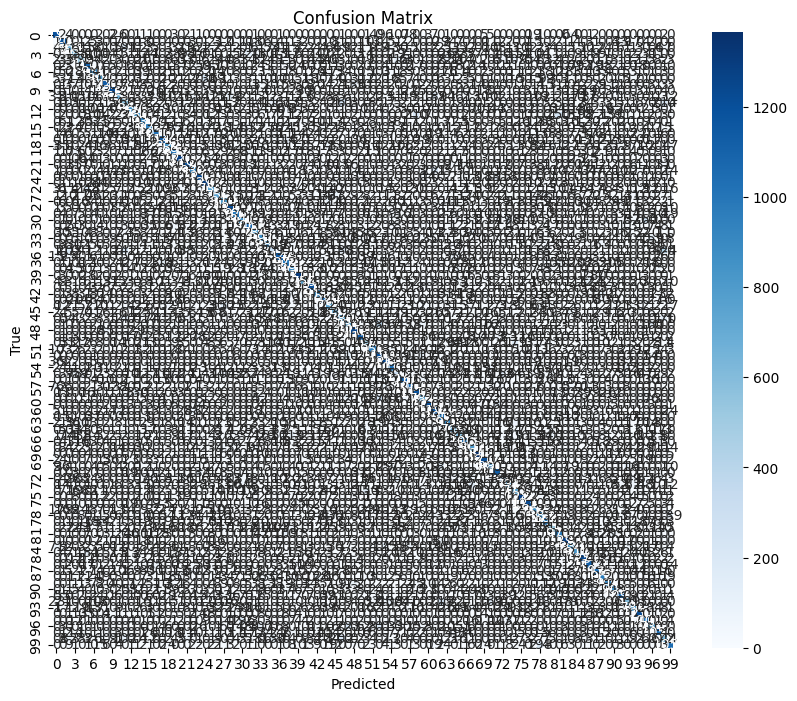

In [13]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.savefig("loss_vs_epoch.png")
plt.show()

plt.figure()
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy vs Epoch")
plt.legend()
plt.savefig("accuracy_vs_epoch.png")
plt.show()

plt.figure()
plt.plot(epochs, val_precisions, label='Precision')
plt.plot(epochs, val_recalls, label='Recall')
plt.plot(epochs, val_f1s, label='F1 Score')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Epoch")
plt.legend()
plt.savefig("metrics_vs_epoch.png")
plt.show()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


In [ ]:
import subprocess
subprocess.run(["nvidia-smi", "-L"])

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-a3c4b7d3-2308-0714-9328-ffe9888b564c)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-5c73ff1d-c5d0-f175-0241-c80dc2a3b970)


CompletedProcess(args=['nvidia-smi', '-L'], returncode=0)

In [ ]:
""" 0, NVIDIA A100-SXM4-40GB, GPU-04d2a6bb-264f-6b50-a917-1effa8949810
1, NVIDIA A100-SXM4-40GB, GPU-ff3ba929-da03-8441-6ab6-0ad20ecbac5f
2, NVIDIA A100-SXM4-40GB, GPU-a3c4b7d3-2308-0714-9328-ffe9888b564c
3, NVIDIA A100-SXM4-40GB, GPU-680b5566-f66c-da58-c59b-1a9e054d807f
4, NVIDIA A100-SXM4-40GB, GPU-72420bd6-f473-9783-fc6a-5894ccc331f2
5, NVIDIA A100-SXM4-40GB, GPU-2beb933a-6d58-ad8e-f216-de8e19ff4ecc
6, NVIDIA A100-SXM4-40GB, GPU-e000602e-d7c7-889e-303d-774fc518edb2
7, NVIDIA A100-SXM4-40GB, GPU-5c73ff1d-c5d0-f175-0241-c80dc2a3b970
(myenv) ir739wb@DGX:~/ilyarekun/nn_DeiT_25$  """